In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from sklearn import tree
import sklearn.linear_model as lm
from sklearn import preprocessing, model_selection, pipeline
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import ensemble
from sklearn import metrics
from sklearn.inspection import permutation_importance

from sklearn import svm

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


np.set_printoptions(precision=3)
pandas.set_option("display.precision", 3)



classification_scores = ['accuracy','precision_weighted',
                         'recall_weighted', 'roc_auc_ovr_weighted',
                         'f1_weighted']


regression_scores = ['explained_variance','neg_mean_absolute_error',
                     'neg_mean_absolute_percentage_error', 'r2',
                     'neg_root_mean_squared_error']

# %matplotlib inline

# Classificacao de Vinhos

## Leitura da Base 

In [2]:
df_wine = pandas.read_csv('../data/dataset_vinhos.csv',sep=';')


wine_target_col = 'target'

wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()

drop_cols = ['target_label']
df_wine.drop(drop_cols, axis=1, inplace=True)
print(df_wine.shape)
df_wine.head()

(5320, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,1,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.998,3.51,0.56,9.4,0,red


## Transformação Variáveis Categóricas

In [3]:
categorical_cols = ['type']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_wine[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_wine = pandas.concat([df_wine, ohe_df], axis=1).drop(cname, axis=1)
df_wine.head()

/home/ciodaro/anaconda3/envs/netlab/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type_red,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,0,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,0,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,0,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,1,1.0,0.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.998,3.51,0.56,9.4,0,1.0,0.0


## Validação Cruzada dos modelos

In [4]:
Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)

# Funcao de teste de hiperparametros por validacao cruzada

def plot_parameter_validation_curve(param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = xtrain, 
                                                 y = ytrain, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=cvfold,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


# Funcao que testa a convergencia de um treinamento pela sua curva de aprendizado
def plot_learning_curve(model, model_name, scoring, train_sizes):
    plt.figure(figsize=(6,4))
    ax = plt.gca()
        
    ax.set_title('Curva de Aprendizado (%s)'%model_name)
    ax.set_xlabel("Exemplos do Treino")
    ax.set_ylabel("Score (" + scoring + ")")

    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X = xtrain,
                                                            y = ytrain,
                                                            cv=cvfold,
                                                            n_jobs=-1,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    ax.grid()
    ax.plot(train_sizes, train_scores_mean, 'o-', color="darkorange",
                 label="Treino")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="navy",
                 label="Validação-cruzada")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="darkorange")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="navy")
    ax.legend(loc="best")
    plt.show()


## Regressão Logística 

### Curva de Validação-Cruzada 

Parâmetros possíveis dict_keys(['C', 'penalty'])
Scores possíveis ['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'f1_weighted']
Parameter: C
GridSearch: [0.01, 0.1, 1, 10]
Scoring: accuracy


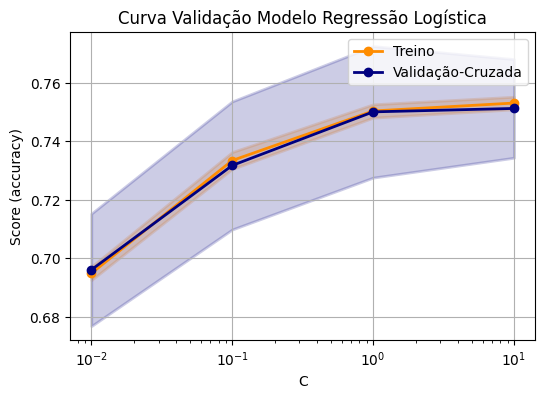

In [5]:

grid_search_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

print('Parâmetros possíveis', grid_search_lr.keys())
print('Scores possíveis', classification_scores)
plot_parameter_validation_curve('C', 
                                grid_search = grid_search_lr,
                                model = lm.LogisticRegression(solver='liblinear'),
                                model_name = 'Regressão Logística',
                                scoring = 'accuracy',
                                logx = True)

# O cientista deve preencher alguns dos parametros para evitar overfitting
# apos a analise acima.
grid_search_lr = {
    'C': [1],
    'penalty': ['l1', 'l2']
}
lr_model = model_selection.GridSearchCV(
    estimator = lm.LogisticRegression(solver='liblinear', C = 1),
    cv=cvfold,
    param_grid = grid_search_lr,
    scoring = classification_scores,
    return_train_score = True,
    refit = 'accuracy',
    
).fit(xtrain, ytrain)


### Curva de Aprendizado 

Scores possíveis ['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'f1_weighted']


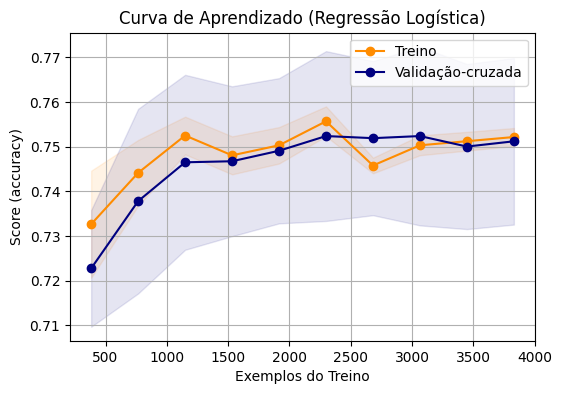

In [6]:

train_sizes = np.linspace(.1, 1.0, 10)

print('Scores possíveis', classification_scores)  
plot_learning_curve(
         model = lr_model.best_estimator_,
         model_name = 'Regressão Logística',
         scoring = 'accuracy',
         train_sizes=train_sizes
)

## Árvore de Decisão 

### Curva de Validação-Cruzada 

Parâmetros possíveis dict_keys(['max_depth', 'criterion', 'min_samples_split', 'max_features'])
Scores possíveis ['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'f1_weighted']
Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Scoring: accuracy


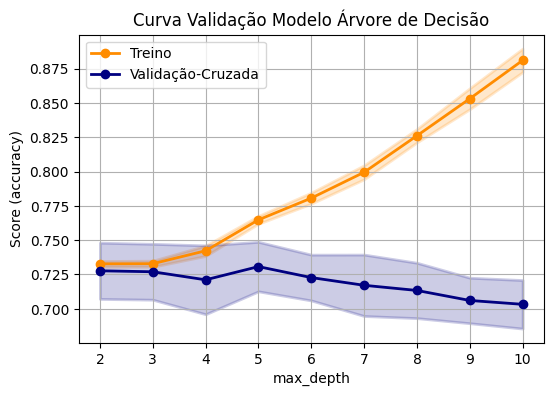

In [7]:

grid_search_dt = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ["auto", "sqrt", "log2"],
}

print('Parâmetros possíveis', grid_search_dt.keys())
print('Scores possíveis', classification_scores)
plot_parameter_validation_curve(
         param_name = 'max_depth', 
         grid_search = grid_search_dt,
         model = tree.DecisionTreeClassifier(),
         model_name = 'Árvore de Decisão',
         scoring = 'accuracy',
         logx = False
)

# O cientista deve preencher alguns dos parametros para evitar overfitting
# apos a analise acima.
grid_search_dt = {
    'max_depth': [5],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ["sqrt", "log2"],
}
dt_model = model_selection.GridSearchCV(
    estimator = tree.DecisionTreeClassifier(),
    cv=cvfold,
    param_grid = grid_search_dt,
    scoring = classification_scores,
    return_train_score = True,
    refit = 'accuracy',
    
).fit(xtrain, ytrain)


### Curva de Aprendizado 

Scores possíveis ['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'f1_weighted']


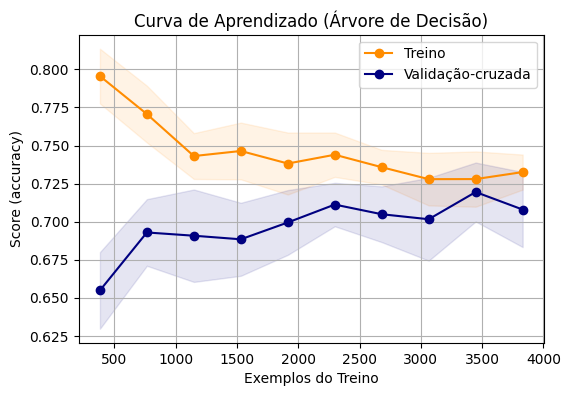

In [8]:
train_sizes = np.linspace(.1, 1.0, 10)
    

print('Scores possíveis', classification_scores)  
plot_learning_curve(
         model = dt_model.best_estimator_,
         model_name = 'Árvore de Decisão',
         scoring = 'accuracy',
         train_sizes=train_sizes
)


## Gradient Boosting Trees

Parâmetros possíveis dict_keys(['max_depth', 'n_estimators', 'criterion', 'learning_rate', 'subsample', 'loss', 'validation_fraction'])
Scores possíveis ['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'f1_weighted']
Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: accuracy


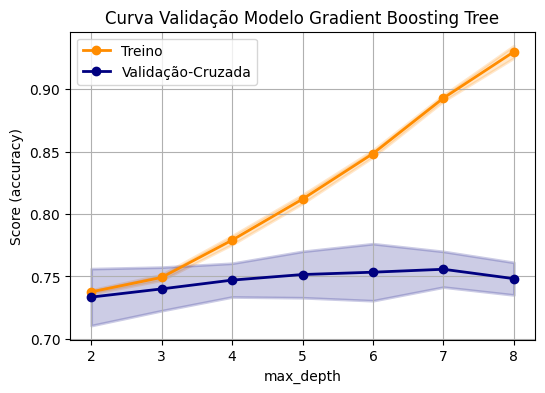

In [9]:

grid_search_gbt = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators': np.arange(4, 30, 2),
    'criterion': ['friedman_mse', 'gini', 'entropy'],
    'learning_rate': [0.001, 0.01, 0.1, 0.7],
    'subsample': [0.5, 0.7, 1.0],
    'loss': ['log_loss'],
    'validation_fraction': [0.05, 0.1, 0.2, 0.3, 0.5],
}

print('Parâmetros possíveis', grid_search_gbt.keys())
print('Scores possíveis', classification_scores)
plot_parameter_validation_curve(
         param_name = 'max_depth', 
         grid_search = grid_search_gbt,
         model = ensemble.GradientBoostingClassifier(n_estimators=18),
         model_name = 'Gradient Boosting Tree',
         scoring = 'accuracy',
         logx = False
)

# O cientista deve preencher alguns dos parametros para evitar overfitting
# apos a analise acima.
grid_search_gbt = {
    'max_depth': [3],
    'n_estimators': [18],
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.1],
    'subsample': [0.7],
}
gbt_model = model_selection.GridSearchCV(
    estimator = ensemble.GradientBoostingClassifier(),
    cv=cvfold,
    param_grid = grid_search_gbt,
    scoring = classification_scores,
    return_train_score = True,
    refit = 'accuracy',
    
).fit(xtrain, ytrain)


## Daframes de Resultados 

In [10]:
# xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)
# Treino
df_train = xtrain.copy()
df_train['modelo_lr' ] = lr_model.predict_proba(xtrain)[:,1]
df_train['modelo_dt' ] = dt_model.predict_proba(xtrain)[:,1]
df_train['modelo_gbt'] = gbt_model.predict_proba(xtrain)[:,1]
df_train['target'] = ytrain
# Teste
df_test = xtest.copy()
df_test['modelo_lr' ] = lr_model.predict_proba(xtest)[:,1]
df_test['modelo_dt' ] = dt_model.predict_proba(xtest)[:,1]
df_test['modelo_gbt'] = gbt_model.predict_proba(xtest)[:,1]
df_test['target'] = ytest

df_wine_model = pandas.concat((df_train, df_test)).reset_index(drop=True)
print(df_wine_model.shape)
print(df_wine_model.head())

# Metricas do treinamento



(5320, 17)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            6.8              0.19         0.34             1.9      0.040   
1            6.7              0.31         0.44             6.7      0.054   
2            7.0              0.31         0.31             9.1      0.036   
3            6.7              0.32         0.44             2.4      0.061   
4            6.8              0.15         0.30             5.3      0.050   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 41.0                 108.0    0.990  3.25       0.45   
1                 29.0                 160.0    0.995  3.04       0.44   
2                 45.0                 140.0    0.992  2.98       0.31   
3                 24.0                  34.0    0.995  3.29       0.80   
4                 40.0                 127.0    0.994  3.40       0.39   

   alcohol  type_red  type_white  modelo_lr  modelo_dt  modelo_gbt  target 

In [11]:


lr_model.cv_results_


{'mean_fit_time': array([0.365, 0.025]),
 'std_fit_time': array([0.055, 0.001]),
 'mean_score_time': array([0.007, 0.009]),
 'std_score_time': array([0., 0.]),
 'param_C': masked_array(data=[1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'penalty': 'l1'}, {'C': 1, 'penalty': 'l2'}],
 'split0_test_accuracy': array([0.721, 0.714]),
 'split1_test_accuracy': array([0.754, 0.756]),
 'split2_test_accuracy': array([0.732, 0.723]),
 'split3_test_accuracy': array([0.751, 0.749]),
 'split4_test_accuracy': array([0.77 , 0.772]),
 'split5_test_accuracy': array([0.744, 0.737]),
 'split6_test_accuracy': array([0.748, 0.753]),
 'split7_test_accuracy': array([0.739, 0.734]),
 'split8_test_accuracy': array([0.772, 0.774]),
 'split9_test_accuracy': array([0.781, 0.788]),
 'mean_test_accuracy': array([0

In [12]:
# loop em modelos
df_model_list = []
for model, model_name in zip([lr_model, dt_model, gbt_model],
                             ['LR', 'DT', 'GBT']):
    # Recuperar o tempo de treinamento
    cvmetrics = ['mean_fit_time', 'std_fit_time']
    cvmetrics.extend([f'mean_train_{s}' for s in classification_scores])
    cvmetrics.extend([f'std_train_{s}' for s in classification_scores])
    cvmetrics.extend([f'mean_test_{s}' for s in classification_scores])
    cvmetrics.extend([f'std_test_{s}' for s in classification_scores])
    # Recuperar somente os valores da Validacao Cruzada para a melhor configuracao de hiperparmetros
    df_data = [model.cv_results_[m][model.best_index_].tolist() for m in cvmetrics]
    df_data = np.array(df_data).reshape(1,-1)
    df_metrics = pandas.DataFrame(data=df_data, columns = cvmetrics)
    df_metrics['modelo'] = model_name 
    df_model_list.append(df_metrics)

# Concatenar resultados
df_metrics = pandas.concat(df_model_list)
df_metrics.head()

,mean_fit_time,std_fit_time,mean_train_accuracy,mean_train_precision_weighted,mean_train_recall_weighted,mean_train_roc_auc_ovr_weighted,mean_train_f1_weighted,std_train_accuracy,std_train_precision_weighted,std_train_recall_weighted,...,mean_test_precision_weighted,mean_test_recall_weighted,mean_test_roc_auc_ovr_weighted,mean_test_f1_weighted,std_test_accuracy,std_test_precision_weighted,std_test_recall_weighted,std_test_roc_auc_ovr_weighted,std_test_f1_weighted,modelo
0,0.365,5.539e-02,0.752,0.748,0.752,0.809,0.747,0.002,0.002,0.002,...,0.747,0.751,0.807,0.746,0.018,0.019,0.018,0.018,0.018,LR
0,0.004,1.324e-04,0.731,0.729,0.731,0.789,0.726,0.008,0.007,0.008,...,0.708,0.713,0.762,0.707,0.025,0.029,0.025,0.028,0.031,DT
0,0.095,2.886e-03,0.753,0.748,0.753,0.828,0.746,0.003,0.003,0.003,...,0.738,0.743,0.805,0.737,0.020,0.021,0.020,0.017,0.020,GBT


## Avaliação dos Modelos

### Matriz de Confusão

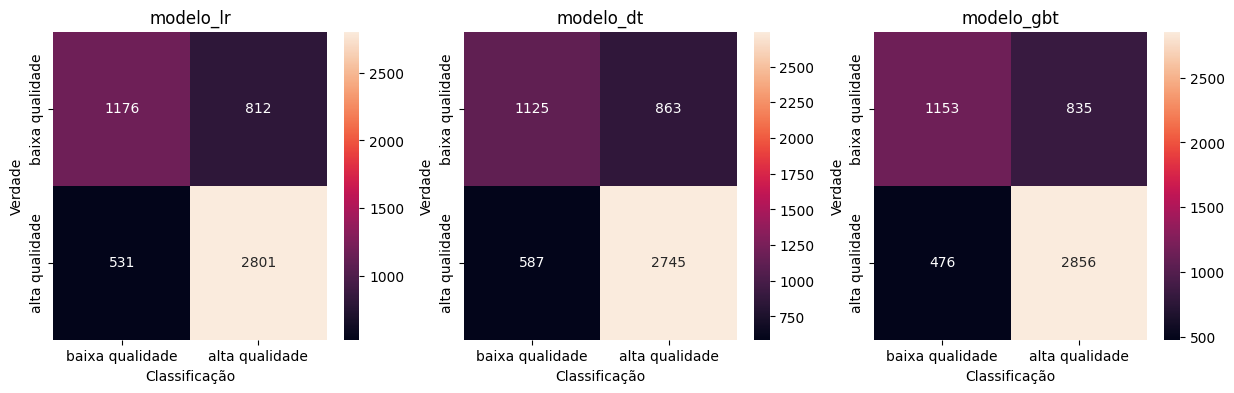

In [13]:

plt.figure(figsize=(15,4))

for i, model in enumerate(['modelo_lr','modelo_dt','modelo_gbt']):
    plt.subplot(1,3,i+1)
    cm = metrics.confusion_matrix(df_wine_model['target'],
                                  df_wine_model[model] > 0.5)
    
    sns.heatmap(cm, annot=True, fmt = '.0f')
    
    plt.title(model)
    plt.xlabel('Classificação')
    plt.ylabel('Verdade')
    plt.gca().set_xticklabels(wine_label_map.target_label.values)
    plt.gca().set_yticklabels(wine_label_map.target_label.values)

### Curva ROC

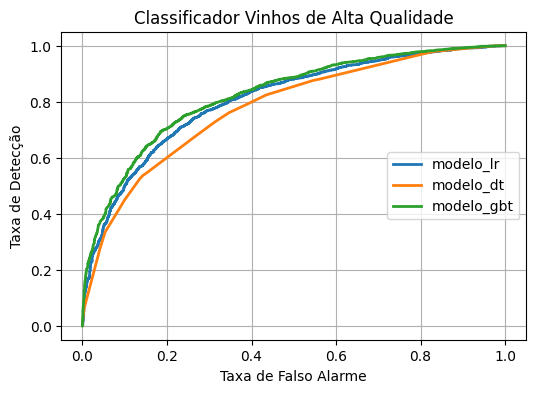

In [14]:
plt.figure(figsize=(6,4))

for i, model in enumerate(['modelo_lr','modelo_dt','modelo_gbt']):
    fpr, tpr, thr = metrics.roc_curve(df_wine_model[wine_target_col],
                                      df_wine_model[model])
    plt.plot(fpr, tpr, '-', lw=2, label=model)
    plt.legend(loc='right')
    plt.title('Classificador Vinhos de Alta Qualidade')
    plt.grid()
    plt.xlabel('Taxa de Falso Alarme')
    plt.ylabel('Taxa de Detecção')

### Distribuição da Saída 

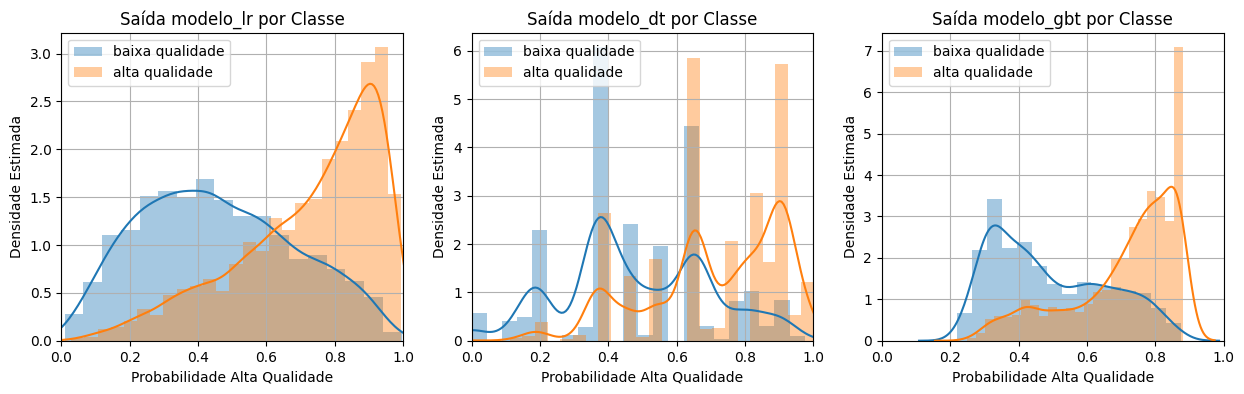

In [15]:
import warnings
warnings.filterwarnings('ignore') # seaborn lanca warning por conta da depreciacao da funcao sns.distplot

plt.figure(figsize=(15,4))

for i, model in enumerate(['modelo_lr','modelo_dt','modelo_gbt']):
    plt.subplot(1,3,i+1)
    for i in wine_label_map.target.unique():
        sns.distplot(df_wine_model[df_wine_model[wine_target_col] == i][model],
                     label=wine_label_map[wine_label_map.target == i].target_label,
                     ax = plt.gca())
    
    plt.title(f'Saída {model} por Classe')
    plt.ylabel('Densidade Estimada')
    plt.xlabel('Probabilidade Alta Qualidade')
    plt.xlim((0,1))
    plt.grid()
    plt.legend()